In [277]:
import numpy as np
from torch import nn
import matplotlib.pyplot as plt
import torch, random
from torch import nn
from copy import deepcopy

Our task is to approximate a sine wave with a neural network. Each different 'task' represents a different sine wave.  
Each `SineWaveTask` is a different sine wave. You can sample points from the sinewave using the `get_training_set` and `get_test_set` methods.

In [283]:
class SineWaveTask:
    def __init__(self):
        self.a = np.random.uniform(0.1, 5.0)
        self.b = np.random.uniform(0, 2*np.pi)
        self.train_x = None
        
    def f(self, x):
        return self.a * np.sin(x + self.b)
        
    def get_training_set(self, size=10, force_new=False):
        """
        Use force_new=True if you want a new set of datapoints from the same sine wave.
        """
        if force_new or self.train_x is None:
            self.train_x = np.random.uniform(-5, 5, size)

        y = self.f(self.train_x)
        return torch.Tensor(self.train_x).view(-1, 1), torch.Tensor(y).view(-1, 1)
    
    def get_test_set(self, size=100):
        x = np.linspace(-5, 5, size)
        y = self.f(x)
        return torch.Tensor(x).view(-1, 1), torch.Tensor(y).view(-1, 1)

### Some Sample Tasks

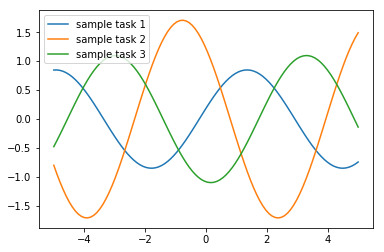

In [284]:
x_1, y_1 = SineWaveTask().get_test_set()
x_2, y_2 = SineWaveTask().get_test_set()
x_3, y_3 = SineWaveTask().get_test_set()

plt.plot(x_1.numpy(), y_1.numpy(), label='sample task 1')
plt.plot(x_2.numpy(), y_2.numpy(), label='sample task 2')
plt.plot(x_3.numpy(), y_3.numpy(), label='sample task 3')
plt.legend()
plt.show()

The model we will use to approximate the sine wave is the similar as that used by OpenAI, a simple MLP. I found using 3 layers instead of 2 help illustrate the results much better.

In [285]:
class SineModel(nn.Module):
    def __init__(self, weights=None):
        super().__init__()
        self.hidden1 = nn.Linear(1, 64)
        self.hidden2 = nn.Linear(64, 64)
        self.hidden3 = nn.Linear(64, 64)
        self.out = nn.Linear(64, 1)
        
        # This lets initialise the weights with those of another model.
        if weights is not None:
            self.load_state_dict(deepcopy(weights))
        
    def forward(self, x):
        x = nn.Tanh()(self.hidden1(x))
        x = nn.Tanh()(self.hidden2(x))
        x = nn.Tanh()(self.hidden3(x))
        return self.out(x)

## Standard Training As A Baseline

First train the MLP on a variety of tasks without metalearning as a baseline. The training is set up to be as similar as possible to what we will do for FOMAML.

In [286]:
def train_model(model, num_tasks=1, k=1):
    optim = torch.optim.Adam(model.parameters(), lr=2e-3, betas=(0, 0.9))
    
    for _ in range(num_tasks):
        task = SineWaveTask()
        
        for i in range(k):
            x, y = task.get_training_set()
            pred_y = model(x)
            loss = nn.MSELoss()(y, pred_y)
            optim.zero_grad()
            loss.backward()
            optim.step()
    return model

def fine_tune_model(model, task, k=1):
    tuned_model = SineModel(weights=model.state_dict())
    optim = torch.optim.SGD(tuned_model.parameters(), lr=0.002)
    
    for _ in range(k):
        x, y = task.get_training_set()
        pred_y = tuned_model(x)
        loss = nn.MSELoss()(y, pred_y)
        optim.zero_grad()
        loss.backward()
        optim.step()
    return tuned_model

### Train a standard model, finetune...
(Takes about 20s on CPU)

In [287]:
model = SineModel()
model = train_model(model, num_tasks=10000, k=2)
task = SineWaveTask()
tuned_model = fine_tune_model(model, task, k=2)

### ... and display the result

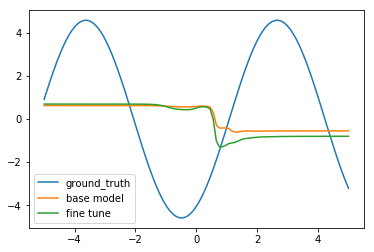

In [288]:
x, y = task.get_test_set()
pred_y = model(x)
tuned_pred_y = tuned_model(x)

plt.plot(x.numpy(), y.numpy(), label='ground_truth')
plt.plot(x.numpy(), pred_y.detach().numpy(), label='base model')
plt.plot(x.numpy(), tuned_pred_y.detach().numpy(), label='fine tune')
plt.legend()

## FOMAML

In [289]:
inner_lr = 0.002
outer_lr = 2e-3

def FOMAML_train(outer_loop_model, num_tasks, k):  
    outer_loop_optim = torch.optim.Adam(outer_loop_model.parameters(), lr=outer_lr, betas=(0, 0.9))
    
    for _ in range(num_tasks):      
        task = SineWaveTask()
        
        inner_loop_model = SineModel(weights=outer_loop_model.state_dict())
        inner_loop_optim = torch.optim.SGD(inner_loop_model.parameters(), lr=inner_lr)
        
        for i in range(k-1): # k-1 as we need to reserve a datapoint to get the final gradient from.
            inner_loop_model = take_inner_loop_train_step(inner_loop_model, task, inner_loop_optim)
            
        # Final datapoint on inner loop
        x, y = task.get_training_set(force_new=True)
        pred_y = inner_loop_model(x)
        loss = nn.MSELoss()(y, pred_y)
        final_grad = torch.autograd.grad(loss, inner_loop_model.parameters())
        
        # Take a step with this grad on the outer model
        for param, grad in zip(outer_loop_model.parameters(), final_grad):
            param.grad = grad
        outer_loop_optim.step()
    
    return model
        

def take_inner_loop_train_step(model, task, optimizer):
    x, y = task.get_training_set(force_new=True)
    pred_y = model(x)
    loss = nn.MSELoss()(y, pred_y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return model
    

def FOMAML_fine_tune(model, task, k):
    new_model = SineModel(weights=model.state_dict())
    inner_loop_optim = torch.optim.SGD(new_model.parameters(), lr=inner_lr)
    for i in range(k-1):
        new_model = take_inner_loop_train_step(new_model, task, inner_loop_optim)
    return new_model

### Train and finetune a FOMAML model...

In [290]:
k = 2  #kshot learning
num_tasks = 10000
model = SineModel()
model = FOMAML_train(model, num_tasks, k)
task = SineWaveTask()
tuned_model = FOMAML_fine_tune(model, task, 2)

### ... and display the results

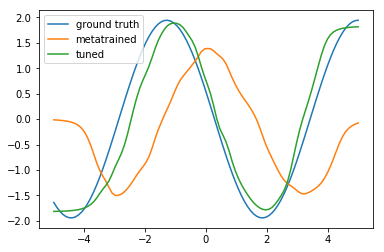

In [291]:
x, y = task.get_test_set()
pred_y = model(x)
tuned_pred_y = tuned_model(x)

plt.plot(x.numpy(), y.numpy(), label='ground truth')
plt.plot(x.numpy(), pred_y.detach().numpy(), label='metatrained')
plt.plot(x.numpy(), tuned_pred_y.detach().numpy(), label='tuned')
plt.legend()

Note that even tune on k=4 instead if k=2 then the results become better still (even though the metatraining occured with k=2)

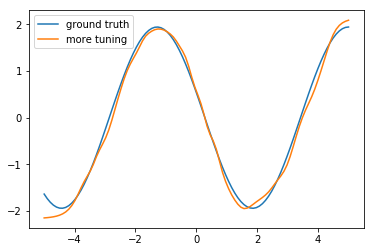

In [292]:
tuned_model = FOMAML_fine_tune(model, task, 4)
tuned_pred_y = tuned_model(x)
plt.plot(x.numpy(), y.numpy(), label='ground truth')
plt.plot(x.numpy(), tuned_pred_y.detach().numpy(), label='more tuning')
plt.legend()

### Notes
Performance is very sensitive to relationship between k and inner loop learning rate.  
It took a decent amount of hyperparameter tuning to get the results working well, a potential area for development.